# Настройки и описание

Тестовый датасет "Linear_Dataset.csv" представляет из себя функцию Y = 0,5 * A + 2 * B + С. А, В, С есть случайное целое число. Модель нейросети - обычная последовательная модель нейросети глубокого обучения с несколькими промежуточными полносвязанными слями Dence и без специализированных дополнительных слоёв. Важно! Код написан для работы с числовыми данными типа int и float.

Подключим Гугл.Диск для сохранения и загрузки моделей

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#! pip install pyyaml h5py  # Требуется для сохранения и загрузки моделей в HDF5-формате

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Настройки

In [3]:
number_of_interations = 1 #Номер итерации для сохранения и загрузки готовой модели
split_percent = 0.85 # Процент данных для обучения

BATCH_SIZE = 5 # Размер пакета для обучения
EPOCHS = 30 # Количество эпох обучения
NN_optimizer = 'adam' # Оптимизатор для модели НС
NN_loss = 'mse' # Функция потерь
csv_file = 'https://raw.githubusercontent.com/AnLiMan/Machine-Learning-Course/main/Datasets/Linear_Dataset.csv'  # Ссылка на датасет
save_path = "/content/drive/My Drive/Files for colab/GWO_NN_model_" + str(number_of_interations) + ".keras" # Путь для сохранения и загрузки моделей нейронки с гугл диска
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  1


# Библиотеки

In [5]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from keras import layers
from tensorflow import keras
import math
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

# Подготовка данных

## Загрузим датасет, выведем некоторую информацию и совершим серию проверок

In [6]:
df = pd.read_csv(csv_file) # Прочтём датасет
df.head() # Выведем заголовок
df.dtypes # Используемые типы данных

A      int64
B      int64
C      int64
Y    float64
dtype: object

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       182 non-null    int64  
 1   B       182 non-null    int64  
 2   C       182 non-null    int64  
 3   Y       182 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 5.8 KB
None


In [8]:
print(df.shape)

(182, 4)


Выделим колонку из датасета, которую нужно будет предсказывать в будущем.

In [9]:
target = df.pop('Y')

Выделим все числовые значения из датсета, строк здесь быть не должно. Эти значения будут независимыми переменными для предсказания target

In [10]:
numeric_feature_names = ['A', 'B', 'C']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,A,B,C
0,18,8,0
1,10,24,17
2,9,13,21
3,24,25,7
4,8,8,2


## Преобразуем данные в массив numpy

In [11]:
data = np.array(numeric_features) # Преобразуем в массив numpy с типом данных float32
data2 = np.array(target)

### Разделим данные на тренировочные и тестовые

In [12]:
n = len(data)
split = int(n*split_percent)
train_X = data[range(split)]
test_X = data[split:]
train_Y = data2[range(split)]
test_Y = data2[split:]

Конвертируем train_X в тенсор

In [13]:
tf.convert_to_tensor(train_X)

<tf.Tensor: shape=(154, 3), dtype=int64, numpy=
array([[18,  8,  0],
       [10, 24, 17],
       [ 9, 13, 21],
       [24, 25,  7],
       [ 8,  8,  2],
       [12,  1, 23],
       [23, 18, 15],
       [23, 12,  1],
       [ 6, 21, 17],
       [ 1,  2, 17],
       [24, 18, 23],
       [19,  9, 20],
       [ 7,  0, 13],
       [25, 10, 19],
       [ 1, 16,  9],
       [24, 14, 19],
       [ 8,  4, 21],
       [11,  5, 14],
       [19, 18,  4],
       [21, 24, 13],
       [12, 23,  4],
       [ 3, 20, 25],
       [13, 15, 18],
       [ 4,  2, 17],
       [12, 11, 24],
       [18, 19, 18],
       [ 2, 17, 13],
       [ 5,  2,  7],
       [ 6,  5,  5],
       [10, 24, 16],
       [18, 20,  7],
       [25,  6, 14],
       [10, 12,  4],
       [10, 17, 16],
       [ 8, 24,  3],
       [ 5,  5,  0],
       [23, 14,  7],
       [10,  3, 14],
       [ 5, 17, 11],
       [12,  3, 15],
       [25, 11,  6],
       [25, 14,  9],
       [15,  6,  2],
       [18, 19, 13],
       [ 6,  8, 23],
       

Нормализуем входные данные

In [14]:
scaler = MinMaxScaler()
scaler.fit(train_X)
normalizer = scaler.fit_transform(train_X)

In [15]:
normalizer = tf.keras.layers.Normalization()

# Модель нейросети

In [16]:
def get_basic_model():
  model = tf.keras.models.Sequential([
  normalizer,
  tf.keras.layers.Flatten(input_shape=(train_X.shape)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1)])

  model.compile(optimizer = NN_optimizer,loss = NN_loss)
  return model

# Обучение нейросети и её сохранение

In [17]:
model = get_basic_model()
history = model.fit(train_X, train_Y, epochs= EPOCHS, batch_size= BATCH_SIZE)
model.summary()
model.save(save_path)

Epoch 1/30
31/31 [==============================] - 2s 8ms/step - loss: 429.0101
Epoch 2/30
31/31 [==============================] - 0s 8ms/step - loss: 6.4922
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.5647
Epoch 4/30
31/31 [==============================] - 0s 8ms/step - loss: 0.2628
Epoch 5/30
31/31 [==============================] - 0s 8ms/step - loss: 0.1595
Epoch 6/30
31/31 [==============================] - 0s 8ms/step - loss: 0.1285
Epoch 7/30
31/31 [==============================] - 0s 9ms/step - loss: 0.0901
Epoch 8/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0732
Epoch 9/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0618
Epoch 10/30
31/31 [==============================] - 0s 9ms/step - loss: 0.0533
Epoch 11/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0283
Epoch 12/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 13/30
31/31 [============================

# Работа с загруженной моделью

In [18]:
Loading_model = tf.keras.models.load_model(save_path)
Loading_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 3)                 7         
 on)                                                             
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                        

## Визуализация результатов

## Проверка точности предсказания

### Прогон по тестовой выборке

In [19]:
for i in range(len(test_X)):
  print("Предсказание при вводных данных " + str(test_X[i]) + " = " + str(Loading_model.predict(test_X[i])))
  print ("Реальное значение = "+ str (test_Y[i]))

1/1 [==============================] - 0s 162ms/step
Предсказание при вводных данных [16  6  7] = [[27.066]]
Реальное значение = 27.0
1/1 [==============================] - 0s 26ms/step
Предсказание при вводных данных [19 18  7] = [[52.29]]
Реальное значение = 52.5
1/1 [==============================] - 0s 29ms/step
Предсказание при вводных данных [25  1  5] = [[19.453]]
Реальное значение = 19.5
1/1 [==============================] - 0s 45ms/step
Предсказание при вводных данных [ 6 25 18] = [[70.862]]
Реальное значение = 71.0
1/1 [==============================] - 0s 46ms/step
Предсказание при вводных данных [19 22  5] = [[58.415]]
Реальное значение = 58.5
1/1 [==============================] - 0s 38ms/step
Предсказание при вводных данных [17  1  4] = [[14.496]]
Реальное значение = 14.5
1/1 [==============================] - 0s 30ms/step
Предсказание при вводных данных [4 2 0] = [[5.98]]
Реальное значение = 6.0
1/1 [==============================] - 0s 47ms/step
Предсказание при вводны

1/1 [==============================] - 0s 158ms/step


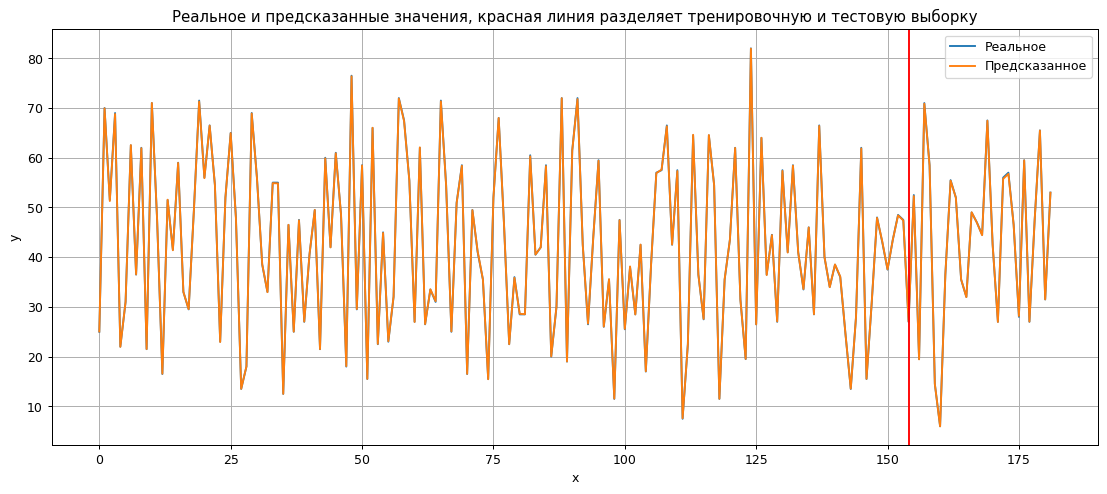

In [22]:
# Графики истиннных значений и предсказаний
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()

# Сделаем предсказания
train_predict = Loading_model.predict(train_X)
test_predict = Loading_model.predict(test_X)
plot_result(train_Y, test_Y, train_predict, test_predict)

### Проверка только на тестовой выборке

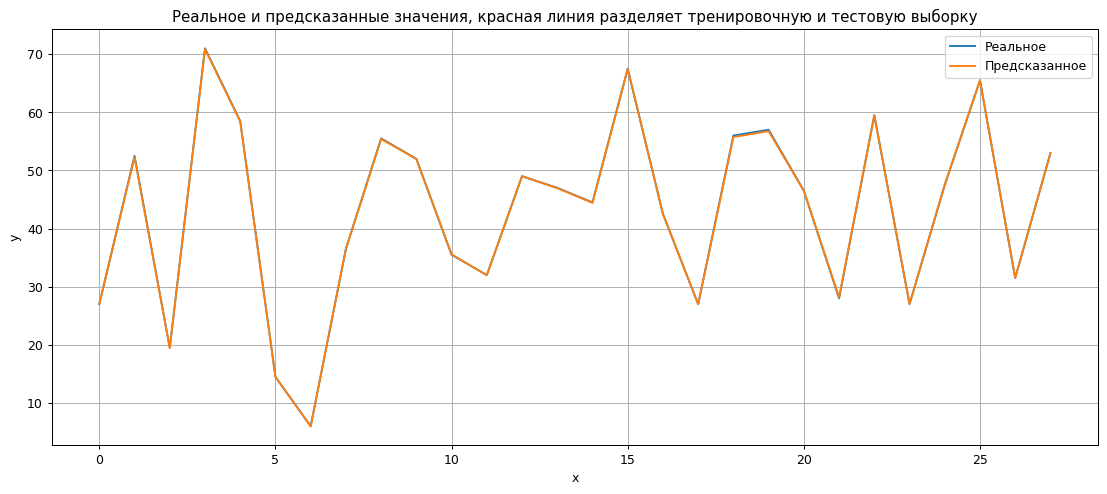

In [23]:
def plot_result(testY , test_predict):
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(test_Y, test_predict)

# Алгоритм оптимизации стаи серых волков GWO для поиска глобального минимума функции

In [24]:
#----Переменные---
iter_number_list = [] #Список значений х для графика
pop = 15 #Численность популяции волков
lb = [0, 0, 0] #Список, нижняя граница (lower boundary) i-го компонента равна lb[i]
ub = [25, 25, 25] #Список, верхняя граница (upper boundary) i-го компонента равна ub[i]
iter = 15 # Количество итераций для алгоритма
round_of_solution = 4 #До кагого знака округляем результаты оптимизации
a_list = [] #Список значений "а"
y_optimized = []

#Инициализация и формулирование проблемы (см. формулы из "Pressure vessel design")
def obj(x):
    print("Вычисление позиции омеги...")
    return Loading_model.predict(x)

#Проверка границ
def boundary_check(x, lb, ub, dim):
    for i in range(dim):
        if x[i] < lb[i]:
            x[i] = lb[i]
        elif x[i] > ub[i]:
            x[i] = ub[i]
    return x

#Основная функция
def main(pop, lb, ub, iter):
    # Шаг 1. Инициализация
    dim = len(ub)  # размерность
    pos = []
    score = []
    iter_best = []  # Наилучшее решение каждой итерации
    for _ in range(pop):
        temp_pos = [random.uniform(lb[i], ub[i]) for i in range(dim)]
        temp_score = obj(temp_pos)
        pos.append(temp_pos)
        score.append(temp_score)
    sorted_score = sorted(score)
    alpha_score = sorted_score[0]
    alpha_pos = pos[score.index(alpha_score)].copy()
    beta_score = sorted_score[1]
    beta_pos = pos[score.index(beta_score)].copy()
    delta_score = sorted_score[2]
    delta_pos = pos[score.index(delta_score)].copy()
    iter_best.append(alpha_score)

    # Шаг 2. Основной цикл
    for t in range(iter):
        iter_number_list.append(t)
        a = 2 - 2 * (t + 1) / iter
        a_list.append(a)
        for i in range(pop):
            for j in range(dim):
                # Вычисление расстояния между альфа
                r1 = random.random()
                r2 = random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - pos[i][j])
                X1 = alpha_pos[j] - A1 * D_alpha

                # Вычисление расстояния между бета
                r1 = random.random()
                r2 = random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_alpha = abs(C2 * beta_pos[j] - pos[i][j])
                X2 = beta_pos[j] - A2 * D_alpha

                # Вычисление расстояния между дельта
                r1 = random.random()
                r2 = random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_alpha = abs(C3 * delta_pos[j] - pos[i][j])
                X3 = delta_pos[j] - A3 * D_alpha

                #Вычисление позиции для агента (омега)
                pos[i][j] = (X1 + X2 + X3) / 3

            # Проверка выхода за границы
            pos[i] = boundary_check(pos[i], lb, ub, dim)

            # Обновление "счёта"
            score[i] = obj(np.array(pos[i]))
            if score[i] < alpha_score:
                alpha_score = score[i]
                alpha_pos = pos[i].copy()
            elif score[i] < beta_score:
                beta_score = score[i]
                beta_pos = pos[i].copy()
            elif score[i] < delta_score:
                delta_score = score[i]
                delta_pos = pos[i].copy()

        iter_best.append(alpha_score)
        y_optimized.append(Loading_model.predict(alpha_score))
        print("\n После итерации " + str(t) + " результат оптимизации = " + str(y_optimized[t]))

    iter_number_list.append(iter + 1)
    a_list.append(0)

    print("\n -----Итоговое решение-----")
    print("A =", round(alpha_pos[0], round_of_solution), "B =", round(alpha_pos[1], round_of_solution + 2), "C =", round(alpha_pos[2], round_of_solution))
    print("Лучший счёт =" + str(alpha_score))

#----Основной код----
main(pop, lb, ub, iter)

Вычисление позиции омеги...
1/1 [==============================] - 0s 116ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 39ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 39ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 41ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 49ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 41ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 42ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 41ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 38ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 40ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 49ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 35ms/step
Вычисление позиции омеги...
1/1 [======